In [1]:
import numpy as np
from qutip import destroy,liouvillian,steadystate,correlation_2op_1t,correlation_3op_1t,tensor, identity,spre,spost,expect, negativity, partial_transpose,ptrace,mesolve,basis
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm

In [2]:
def Liouv(γΣ, ΔΣ, ΩΣ):
    return np.array([
        [0, -1j*ΩΣ, 1j*ΩΣ, -γΣ],
        [-1j*ΩΣ, -1j*ΔΣ + γΣ/2, 0, 1j*ΩΣ],
        [1j*ΩΣ, 0, 1j*ΔΣ + γΣ/2, -1j*ΩΣ],
        [0, 1j*ΩΣ, -1j*ΩΣ, γΣ]
    ])

def Omega_side(γΣ, ΔΣ, ΩΣ):
    eigenvalues = np.linalg.eigvals(Liouv(γΣ, ΔΣ, ΩΣ))
    return np.imag(eigenvalues)[0]

In [3]:
# create operators
N=4 #Detector max number
σ = tensor(identity(N),identity(N),destroy(2))
a = tensor(destroy(N),identity(N),identity(2))
b = tensor(identity(N),destroy(N), identity(2))

The Hamiltonian and cascaded master equation are given by, 
$$H_{σ}=\Delta_{\sigma}\sigma^\dagger\sigma+\Omega_\sigma(\sigma^\dagger+\sigma)\\
H_{d}=\Delta_a a^\dagger a +\Delta_b b^\dagger b \\
\partial_t\rho = i[\rho,H_\sigma +H_d]+(\gamma_\sigma/2)\mathcal{L}_{\sigma}(\rho)+(\Gamma/2)\mathcal{L}_{a}(\rho)+(\Gamma/2)\mathcal{L}_{b}(\rho)\\ 
-\sqrt{\gamma_\sigma \Gamma /2}\lbrace [a^\dagger, \sigma\rho]+[\rho\sigma^\dagger,a]\rbrace-\sqrt{\gamma_\sigma \Gamma /2}\lbrace [b^\dagger, \sigma\rho]+[\rho\sigma^\dagger,b]\rbrace
$$

In [8]:
def Time_dependence(ΔΣ,ΔA,ΔB,ΩΣ,γΣ,Γdet,tlist):
    H =  ΔΣ* σ.dag() * σ + ΔA * a.dag() * a + ΔB * b.dag() * b + ΩΣ * (σ.dag() + σ)
    c_ops=[np.sqrt(γΣ) * σ, np.sqrt(Γdet) * a, np.sqrt(Γdet) * b]

    # master equation superoperators
    L0 = liouvillian(H, c_ops)
    L1 = -np.sqrt(Γdet * γΣ * 0.5) * (
        spre(a.dag() * σ)
        - spre(σ) * spost(a.dag())
        + spost(σ.dag() * a)
        - spre(a) * spost(σ.dag())
    ) -np.sqrt(Γdet * γσ * 0.5) * (
        spre(b.dag() * σ)
        - spre(σ) * spost(b.dag())
        + spost(σ.dag() * b)
        - spre(b) * spost(σ.dag())
    )
    L = L0 + L1    
    psi0 = tensor(basis(N, 0), basis(N, 0), basis(2, 1))
    result = mesolve(L, psi0, tlist, c_ops, [σ.dag() * σ, a.dag() * a, b.dag() * b])
    excited_state_pop = result.expect[0]
    det1_pop = result.expect[1]
    det2_pop = result.expect[2]
    G2ab = np.real(correlation_3op_1t(L, psi0, tlist, c_ops, a.dag(), b.dag() * b , a)) 
    G2σ = np.real(correlation_3op_1t(L, psi0, tlist, c_ops, σ.dag(), σ.dag() * σ , σ))
    g2ab = np.array(G2ab)/ (det1_pop[0] * np.array(det2_pop))
    g2σ = np.array(G2σ)/ (excited_state_pop[0] * np.array(excited_state_pop))
    return excited_state_pop, det1_pop, det2_pop, g2ab, g2σ

In [15]:
γσ=1
Δσ=0
Ωσ=2*γσ 
Γ=γσ 
tlist= np.linspace(0,10,1000)
ΩRabi=Omega_side(γσ, Δσ, Ωσ)

In [16]:
excited_state_pop, det1_pop, det2_pop, g2ab, g2σ  = Time_dependence(Δσ,ΩRabi,-ΩRabi,Ωσ,γσ,Γ,tlist)

C:\Users\santi\AppData\Local\Temp\ipykernel_39072\242874749.py:26: RuntimeWarning: invalid value encountered in divide
  g2ab = np.array(G2ab)/ (det1_pop[0] * np.array(det2_pop))


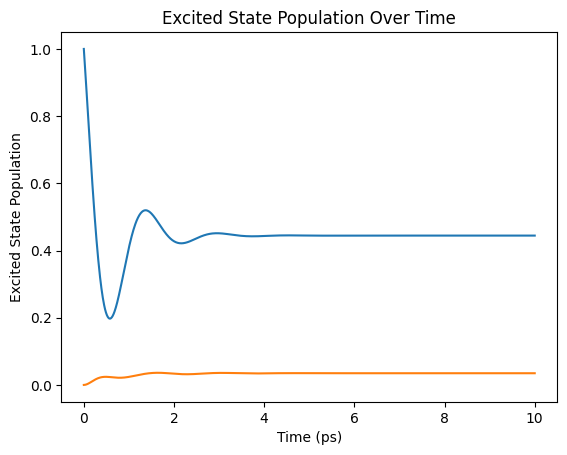

In [17]:
# Plot the excited state population
plt.plot(tlist, excited_state_pop)
plt.plot(tlist, det1_pop)
plt.xlabel('Time (ps)')
plt.ylabel('Excited State Population')
plt.title('Excited State Population Over Time')
plt.show()

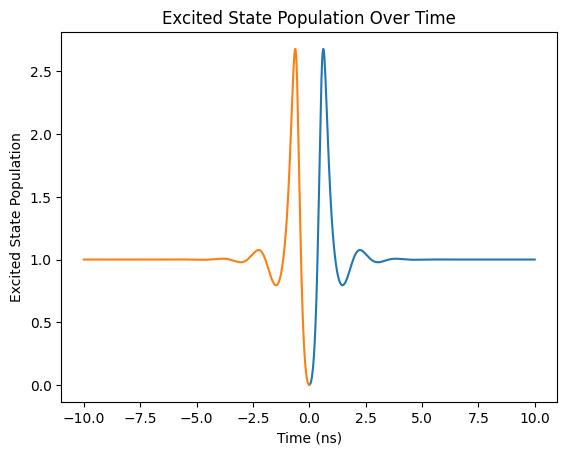

In [21]:
# Plot the excited state population
plt.plot(tlist*γσ, g2σ)
plt.plot(-tlist*γσ, g2σ)
plt.xlabel('Time (ns)')
plt.ylabel('Excited State Population')
plt.title('Excited State Population Over Time')
plt.show()

In [ ]:
import qutip

N = 25
taus = np.linspace(0, 25.0, 200)
a = qutip.destroy(N)
H = 2 * np.pi * a.dag() * a
kappa = 0.25
n_th = 2.0 # bath temperature in terms of excitation number
c_ops = [np.sqrt(kappa * (1 + n_th)) * a, np.sqrt(kappa * n_th) * a.dag()]
states = [
{'state': qutip.coherent_dm(N, np.sqrt(2)), 'label': "coherent state"},
{'state': qutip.thermal_dm(N, 2), 'label': "thermal state"},
{'state': qutip.fock_dm(N, 2), 'label': "Fock state"},
]
fig, ax = plt.subplots(1, 1)
for state in [states[-1]]:
    rho0 = state['state']
    # first calculate the occupation number as a function of time
    n = qutip.mesolve(H, rho0, taus, c_ops, [a.dag() * a]).expect[0]
    # calculate the correlation function G2 and normalize with n(0)n(t) to
    # obtain g2
    G2 = qutip.correlation_3op_1t(H, rho0, taus, c_ops, a.dag(), a.dag()*a, a)
    g2 = np.array(G2) / (n[0] * np.array(n))
    ax.plot(taus, np.real(g2), label=state['label'], lw=2)
ax.legend(loc=0)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$g^{(2)}(\tau)$')
plt.show()

In [ ]:
G2

# $g^{(2)}(\tilde{\omega}_a,\tilde{\omega}_b;\tau=0)$

In [ ]:
def G2SS_Solver(ΔΣ,ΔA,ΔB,ΩΣ,γΣ,Γdet):
    H =  ΔΣ* σ.dag() * σ + ΔA * a.dag() * a + ΔB * b.dag() * b + ΩΣ * (σ.dag() + σ)
    c_ops=[np.sqrt(γΣ) * σ, np.sqrt(Γdet) * a, np.sqrt(Γdet) * b]

    # master equation superoperators
    L0 = liouvillian(H, c_ops)
    L1 = -np.sqrt(Γdet * γΣ * 0.5) * (
        spre(a.dag() * σ)
        - spre(σ) * spost(a.dag())
        + spost(σ.dag() * a)
        - spre(a) * spost(σ.dag())
    ) -np.sqrt(Γdet * γσ * 0.5) * (
        spre(b.dag() * σ)
        - spre(σ) * spost(b.dag())
        + spost(σ.dag() * b)
        - spre(b) * spost(σ.dag())
    )
    L = L0 + L1    
    ρss= steadystate(L)
    #Cross correlation functions
    G2ab = np.real(correlation_3op_1t(L, ρss, [0], c_ops, a.dag(), b.dag() * b , a))
    na = correlation_2op_1t(L, ρss, [0], c_ops, a.dag(), a)
    nb = correlation_2op_1t(L, ρss, [0], c_ops, b.dag(), b)    
    g2ab=G2ab/(na *nb)
    return np.log10(np.real(g2ab[0]))

In [ ]:
def g2abss(ΔΣ,ΔA,ΔB,ΩΣ,γΣ,Γdet):
    H =  ΔΣ* σ.dag() * σ + ΔA * a.dag() * a + ΔB * b.dag() * b + ΩΣ * (σ.dag() + σ)
    c_ops=[np.sqrt(γΣ) * σ, np.sqrt(Γdet) * a, np.sqrt(Γdet) * b]

    # master equation superoperators
    L0 = liouvillian(H, c_ops)
    L1 = -np.sqrt(Γdet * γΣ * 0.5) * (
        spre(a.dag() * σ)
        - spre(σ) * spost(a.dag())
        + spost(σ.dag() * a)
        - spre(a) * spost(σ.dag())
    ) -np.sqrt(Γdet * γσ * 0.5) * (
        spre(b.dag() * σ)
        - spre(σ) * spost(b.dag())
        + spost(σ.dag() * b)
        - spre(b) * spost(σ.dag())
    )
    L = L0 + L1    
    ρss= steadystate(L)    
    G2ab = expect(a.dag() * b.dag() * b * a, ρss)
    na = expect(a.dag() * a, ρss)
    nb = expect(b.dag() * b, ρss)
    return np.log10(np.real( G2ab / (na * nb)))

In [ ]:
γσ=1
Δσ=0
Ωσ=5*γσ 
Γ=γσ 

ΩRabi=Omega_side(γσ, Δσ, Ωσ)

In [ ]:
round(G2SS_Solver(Δσ,0,0,Ωσ,γσ,Γ),5)==round(g2abss(Δσ,0,0,Ωσ,γσ,Γ),5)

In [ ]:
G2SS_Solver(Δσ, 0, 0, Ωσ, γσ, Γ)

In [ ]:
Δa_values = ΩRabi *np.linspace(-2, 2, 101)
Δb_values = ΩRabi *np.linspace(-2, 2, 101)

g2ab_values = np.zeros((len(Δa_values), len(Δb_values)))

for i, Δa in enumerate(Δa_values):
    for j, Δb in enumerate(Δb_values):
        g2ab_values[i, j] = G2SS_Solver(Δσ, Δa, Δb, Ωσ, γσ, Γ)

In [ ]:
mn = g2ab_values.min()
Mx = g2ab_values.max()

colors = [(0, "blue"), ((0 - mn) / (Mx - mn), "white"), (1, "red")]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

plt.figure(figsize=(8, 6))
plt.imshow(g2ab_values, extent=[Δa_values.min()/ΩRabi, Δa_values.max()/ΩRabi, Δb_values.min()/ΩRabi, Δb_values.max()/ΩRabi],
           origin='lower', aspect='auto', cmap=cmap, vmin=mn, vmax=Mx)
plt.plot(Δa_values / ΩRabi, -Δa_values / ΩRabi, linestyle='--', color=(102/255,0,0), alpha=0.7, label='$\\tilde{\\omega}_{a} + \\tilde{\\omega}_{b} = 0$')
plt.plot(Δa_values / ΩRabi, (ΩRabi - Δa_values) / ΩRabi, linestyle='--', color=(0,0,102/255), alpha=0.7, label='$\\tilde{\\omega}_{a} + \\tilde{\\omega}_{b} =+\\Omega_{R}$')
plt.plot(Δa_values / ΩRabi, (-ΩRabi - Δa_values) / ΩRabi, linestyle='--', color=(0,102/255,0), alpha=0.7, label='$\\tilde{\\omega}_{a} + \\tilde{\\omega}_{b} =-\\Omega_{R}$')
plt.colorbar(label='$\\log[g^{(2)}_{ab}(0)]$')
plt.xlabel('$\\tilde{\\omega}_{a}/\\Omega_{R}$')
plt.ylabel('$\\tilde{\\omega}_{b}/\\Omega_{R}$')
plt.title('$g^{(2)}_{ab}(0)$')

plt.xlim([-2, 2])
plt.ylim([-2, 2])

plt.legend()
plt.show()

In [ ]:
mn = g2ab_values.min()
Mx = g2ab_values.max()

colors = [(0, "blue"), ((0 - mn) / (Mx - mn), "white"), (1, "red")]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [3, 1]})

im = ax1.imshow(g2ab_values, extent=[Δa_values.min()/ΩRabi, Δa_values.max()/ΩRabi, Δb_values.min()/ΩRabi, Δb_values.max()/ΩRabi],
                origin='lower', aspect='auto', cmap=cmap, vmin=mn, vmax=Mx)
ax1.plot(Δa_values / ΩRabi, -Δa_values / ΩRabi, linestyle='--', color=(102/255,0,0), alpha=0.7, label='$\\tilde{\\omega}_{a} + \\tilde{\\omega}_{b} = 0$')
ax1.plot(Δa_values / ΩRabi, (ΩRabi - Δa_values) / ΩRabi, linestyle='--', color=(0,0,102/255), alpha=0.7, label='$\\tilde{\\omega}_{a} + \\tilde{\\omega}_{b} = +\\Omega_{R}$')
ax1.plot(Δa_values / ΩRabi, (-ΩRabi - Δa_values) / ΩRabi, linestyle='--', color=(0,102/255,0), alpha=0.7, label='$\\tilde{\\omega}_{a} + \\tilde{\\omega}_{b} = -\\Omega_{R}$')
ax1.set_xlabel('$\\tilde{\\omega}_{a}/\\Omega_{R}$')
ax1.set_ylabel('$\\tilde{\\omega}_{b}/\\Omega_{R}$')
ax1.set_title('$g^{(2)}_{ab}(0)$')
ax1.set_xlim([-2, 2])
ax1.set_ylim([-2, 2])
ax1.legend()

cbar = fig.colorbar(im, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('$\\log[g^{(2)}_{ab}(0)]$')

diagonal_values = np.array([g2ab_values[i, i] for i in range(len(Δa_values))])
diagonal_freq = Δa_values / ΩRabi

ax2.plot(diagonal_values, diagonal_freq, color='black')
ax2.set_xlabel('$\\log[g^{(2)}_{ab}(0)]$')
ax2.set_ylabel('$\\tilde{\\omega}/\\Omega_{R}$')
ax2.set_title('$\\tilde{\\omega}_{a} = \\tilde{\\omega}_{b}$')
ax2.set_ylim([-2, 2])

plt.tight_layout()
plt.show()

# $g^{(2)}(\tilde{\omega}_a,\tilde{\omega}_b;\tau)$

In [ ]:
γσ=1 
Ωσ=1*γσ 
Γ=γσ 
Δσ=1.85 * Ωσ

ΩRabi=abs(Omega_side(γσ, Δσ, Ωσ))

In [ ]:
tau_list_pos = γσ * np.linspace(0, 20, 1000)  
tau_list_neg = γσ * np.linspace(-10, 0, 1000)  

In [ ]:
def G2τ_Solver(Δσ, Δa, Δb, Ωσ, γσ, Γdet, tau_list):
    H = Δσ * σ.dag() * σ + Δa * a.dag() * a + Δb * b.dag() * b + Ωσ * (σ.dag() + σ)
    c_ops = [np.sqrt(γσ) * σ, np.sqrt(Γdet) * a, np.sqrt(Γdet) * b]

    # Master equation superoperators
    L0 = liouvillian(H, c_ops)
    L1 = -np.sqrt(Γdet * γσ * 0.5) * (
        spre(a.dag() * σ)
        - spre(σ) * spost(a.dag())
        + spost(σ.dag() * a)
        - spre(a) * spost(σ.dag())
    ) - np.sqrt(Γdet * γσ * 0.5) * (
        spre(b.dag() * σ)
        - spre(σ) * spost(b.dag())
        + spost(σ.dag() * b)
        - spre(b) * spost(σ.dag())
    )
    L = L0 + L1    
    ρss = steadystate(L)

    # Cross correlation functions
    G2ab = np.real(correlation_3op_1t(L, ρss, tau_list, [], a.dag(), b.dag() * b, a))
    na = correlation_2op_1t(L, ρss, [0], [], a.dag(), a)
    nb = correlation_2op_1t(L, ρss, [0], [], b.dag(), b)    
    g2ab=G2ab / (na * nb)
    #g2a = coherence_function_g2(L, ρss, tau_list, c_ops, a, solver='me', args=None, options=None) 
    return np.real(g2ab)


In [ ]:
g2_values_pos = G2τ_Solver(Δσ, ΩRabi, -ΩRabi, Ωσ, γσ, Γ, tau_list_pos)
g2_values_neg = G2τ_Solver(Δσ, ΩRabi, -ΩRabi, Ωσ, γσ, Γ, tau_list_neg)


plt.figure(figsize=(8, 6))
plt.plot(tau_list_pos, g2_values_pos)
plt.xlabel('τ (time delay)')
plt.ylabel('$g^{(2)}_{ab}(τ)$')
plt.show()

# $\mathcal{N}(\rho)$

In [ ]:
def log_negativity(rho, subsys, method='tracenorm', logarithmic=False):
    reduced_rho = ptrace(rho, [0,1])
    
    mask = [idx == subsys for idx, n in enumerate(reduced_rho.dims[0])]
    rho_pt = partial_transpose(reduced_rho, mask)
    
    if method == 'tracenorm':
        N = ((rho_pt.dag() * rho_pt).sqrtm().tr().real - 1) / 2.0
    elif method == 'eigenvalues':
        l = rho_pt.eigenenergies()
        N = ((abs(l) - l) / 2).sum()
    else:
        raise ValueError(f"Unknown method {method}")

    if logarithmic:
        return np.log2(2 * N + 1)
    else:
        return N

In [ ]:
γσ=1 
Ωσ= 10 * γσ 
Γ=1 * γσ 
Δσ=0 * Ωσ
ΩRabi=abs(Omega_side(γσ, Δσ, Ωσ))

In [ ]:
def LogNeg_Solver(ΔΣ,ΔA,ΔB,ΩΣ,γΣ,Γdet):
    
    H =  ΔΣ* σ.dag() * σ + ΔA * a.dag() * a + ΔB * b.dag() * b + ΩΣ * (σ.dag() + σ)
    c_ops=[np.sqrt(γΣ) * σ, np.sqrt(Γdet) * a, np.sqrt(Γdet) * b]

    L0 = liouvillian(H, c_ops)
    L1 = -np.sqrt(Γdet * γΣ * 0.5) * (
        spre(a.dag() * σ)
        - spre(σ) * spost(a.dag())
        + spost(σ.dag() * a)
        - spre(a) * spost(σ.dag())
    ) -np.sqrt(Γdet * γσ * 0.5) * (
        spre(b.dag() * σ)
        - spre(σ) * spost(b.dag())
        + spost(σ.dag() * b)
        - spre(b) * spost(σ.dag())
    )
    L = L0 + L1    
    ρss= steadystate(L)   
    lognegvalue=log_negativity(ρss, subsys=0, method='tracenorm', logarithmic=True)
    return lognegvalue

In [ ]:
Δa_values = ΩRabi *np.linspace(-2, 2, 201)
Δb_values = ΩRabi *np.linspace(-2, 2, 201)

logneg_values = np.zeros((len(Δa_values), len(Δb_values)))

for i, Δa in enumerate(Δa_values):
    for j, Δb in enumerate(Δb_values):
        logneg_values[i, j] = LogNeg_Solver(Δσ, Δa, Δb, Ωσ, γσ, Γ)

In [ ]:
#np.savetxt("Data/Logneg_O10_Gp5_D2.2O.dat", logneg_values, delimiter=";")

In [ ]:
mn = logneg_values.min()
Mx = logneg_values.max()


plt.figure(figsize=(8, 6))
plt.imshow(logneg_values, extent=[Δa_values.min()/ΩRabi, Δa_values.max()/ΩRabi, Δb_values.min()/ΩRabi, Δb_values.max()/ΩRabi],
           origin='lower', aspect='auto', cmap="inferno_r")
plt.plot(Δa_values / ΩRabi, -Δa_values / ΩRabi, linestyle='--', color=(102/255,0,0), alpha=0.7, label='$\\tilde{\\omega}_{a} + \\tilde{\\omega}_{b} = 0$')
plt.plot(Δa_values / ΩRabi, (ΩRabi - Δa_values) / ΩRabi, linestyle='--', color=(0,0,102/255), alpha=0.7, label='$\\tilde{\\omega}_{a} + \\tilde{\\omega}_{b} =+\\Omega_{R}$')
plt.plot(Δa_values / ΩRabi, (-ΩRabi - Δa_values) / ΩRabi, linestyle='--', color=(0,102/255,0), alpha=0.7, label='$\\tilde{\\omega}_{a} + \\tilde{\\omega}_{b} =-\\Omega_{R}$')
plt.colorbar(label='$\\mathcal{N}(\\rho)$')
plt.xlabel('$\\tilde{\\omega}_{a}/\\Omega_{R}$')
plt.ylabel('$\\tilde{\\omega}_{b}/\\Omega_{R}$')
plt.title('$\\mathcal{N}(\\rho)\\;\\text{for}\\;\\Delta = {Δσ}\\Omega$')

plt.xlim([-2, 2])
plt.ylim([-2, 2])

plt.legend()
plt.show()

In [ ]:
np.savetxt("Data/Logneg_O10_G1_D0O.dat", logneg_values, delimiter=";")